## 预测最后一个值

为演示训练RNN，可以根据可用的历史数据预测时间序列中的最后一个值，我们定义一个合成数据集。

In [1]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [2]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

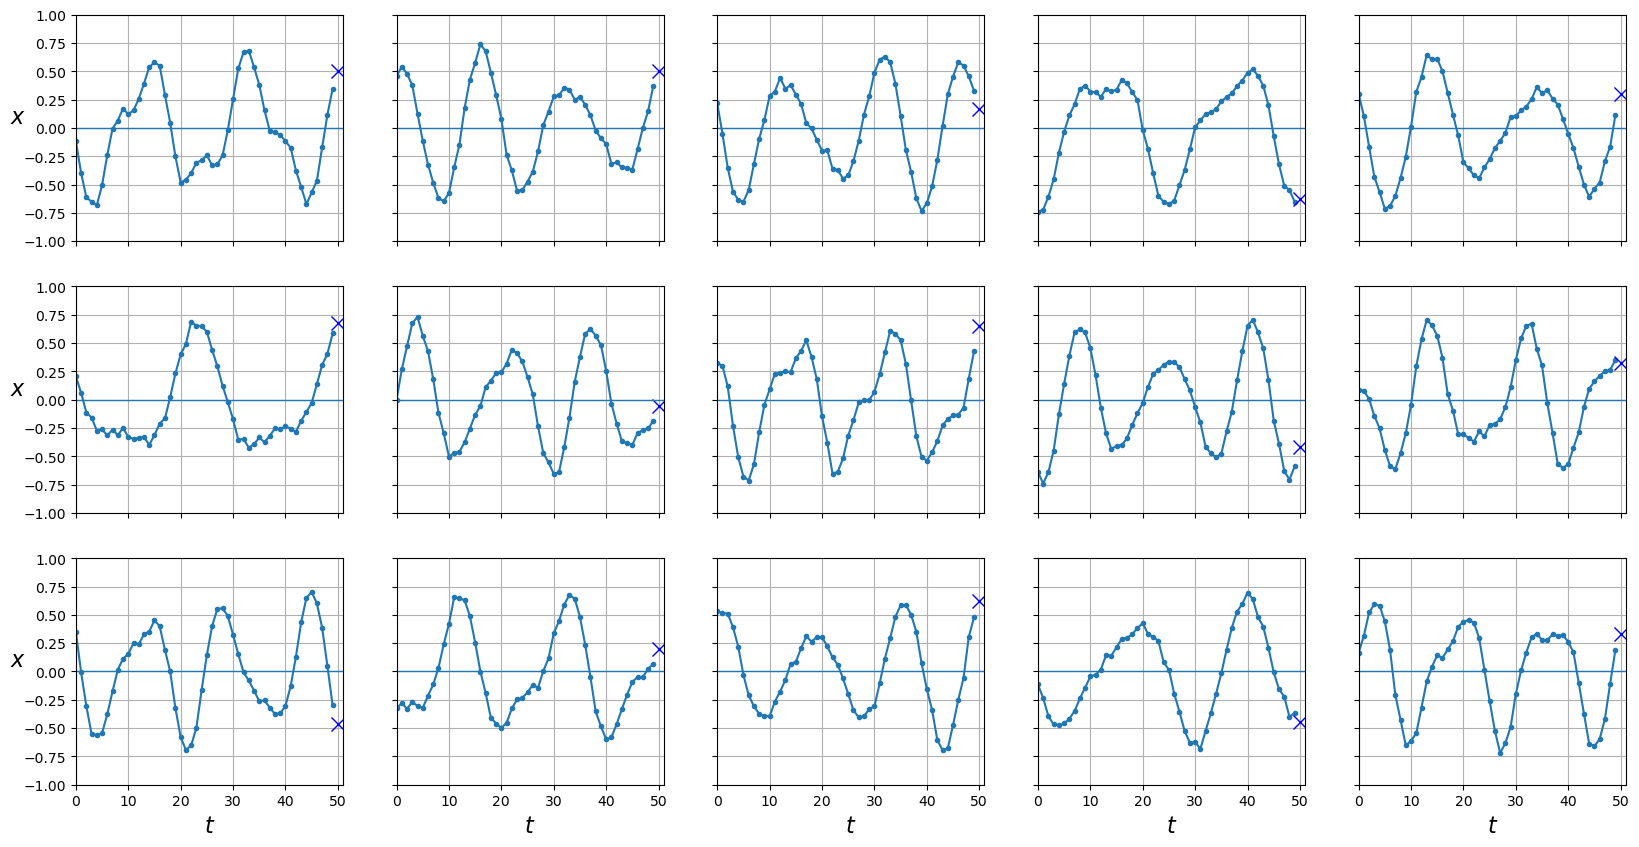

In [3]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

我们训练一个RNN模型，它接受一个单一的输入值，连接到隐藏层中的20个神经元，最后一个时间步获得的20个结果值与一个神经元连接，产生预测的最终结果。

In [5]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [6]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [7]:
fit(rnn, dataloader)

loss 0.00390 val_loss 0.00402: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


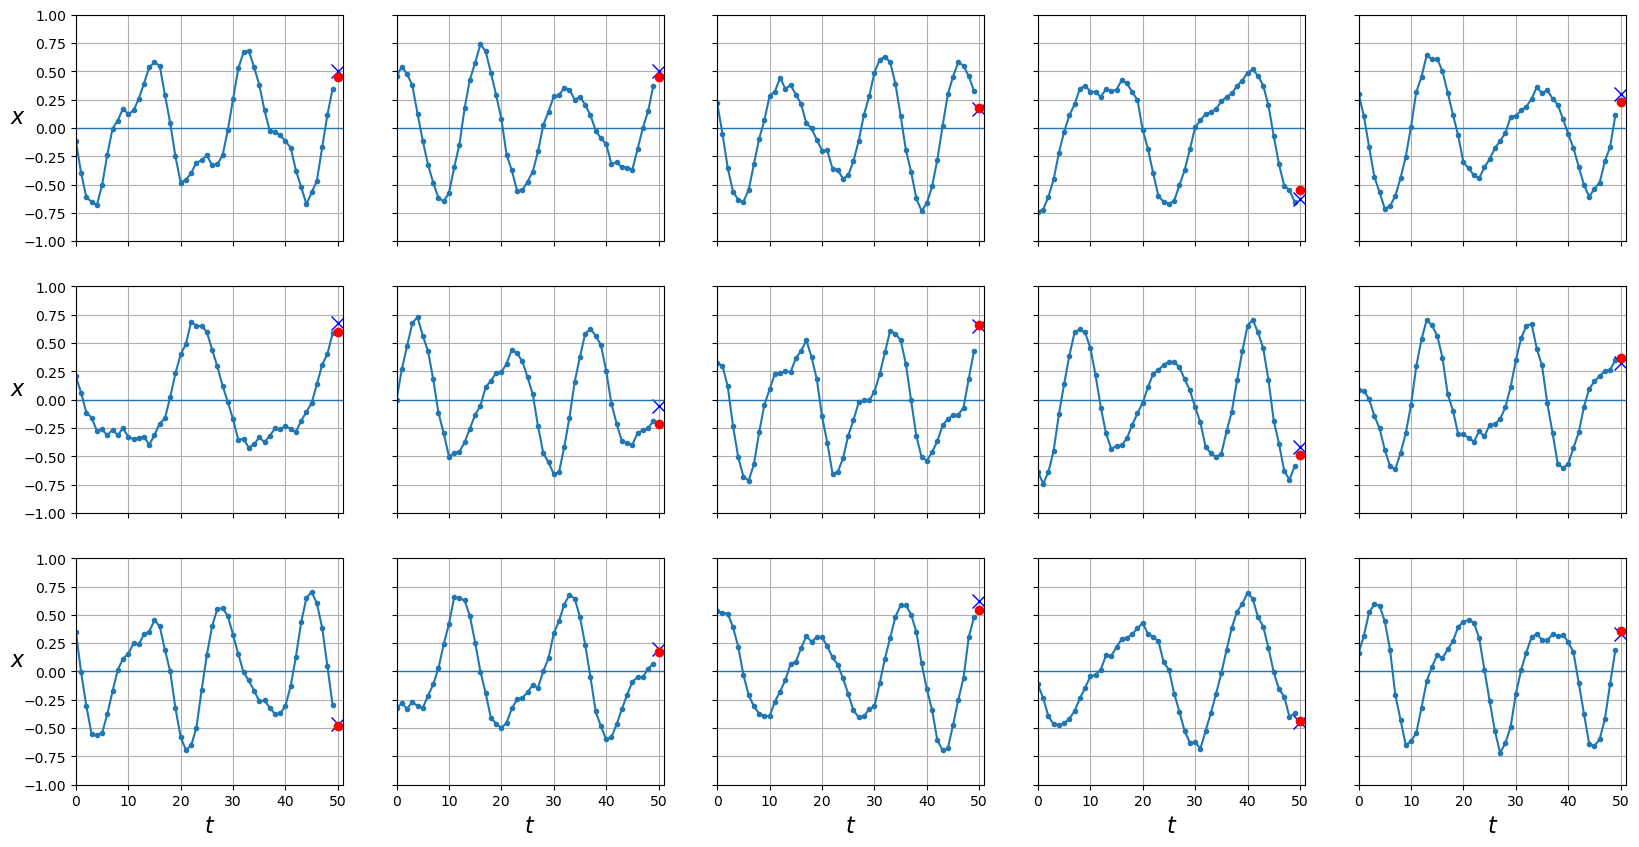

0.003979258704930544

In [8]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

我们可以通过在所谓的RNN模型中添加更多隐藏层来改进模型。这将增加模型的能力，也可能会提高模型的性能。

In [9]:
# 使用 num_layers参数来控制循环神经网络（RNN）中的隐藏层数量
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [10]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.00348 val_loss 0.00414: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


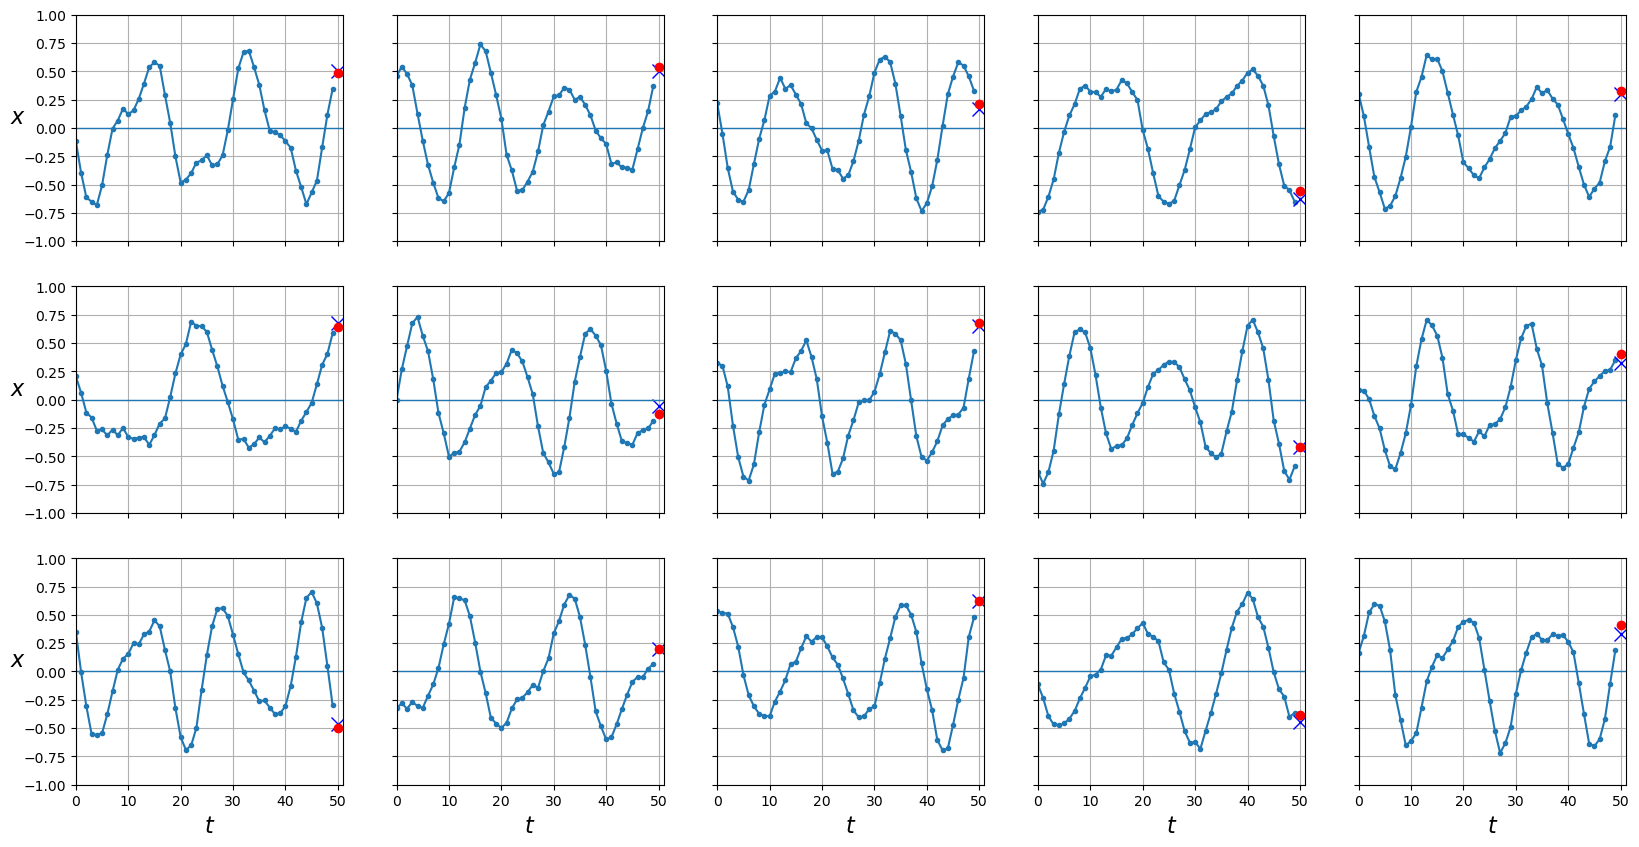

0.0043603465892374516

In [11]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

## 预测多个值

对时间序列中的最后一个值的预测，帮助我们了解了RNN的工作原理。但是这种应用情况并不是很有用。能够预测一整个星期、一个月甚至一年的值，可以为相关应用带来更多价值。

让我们看看如何根据可用的历史数据预测时间序列中的最后10个值。

In [12]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

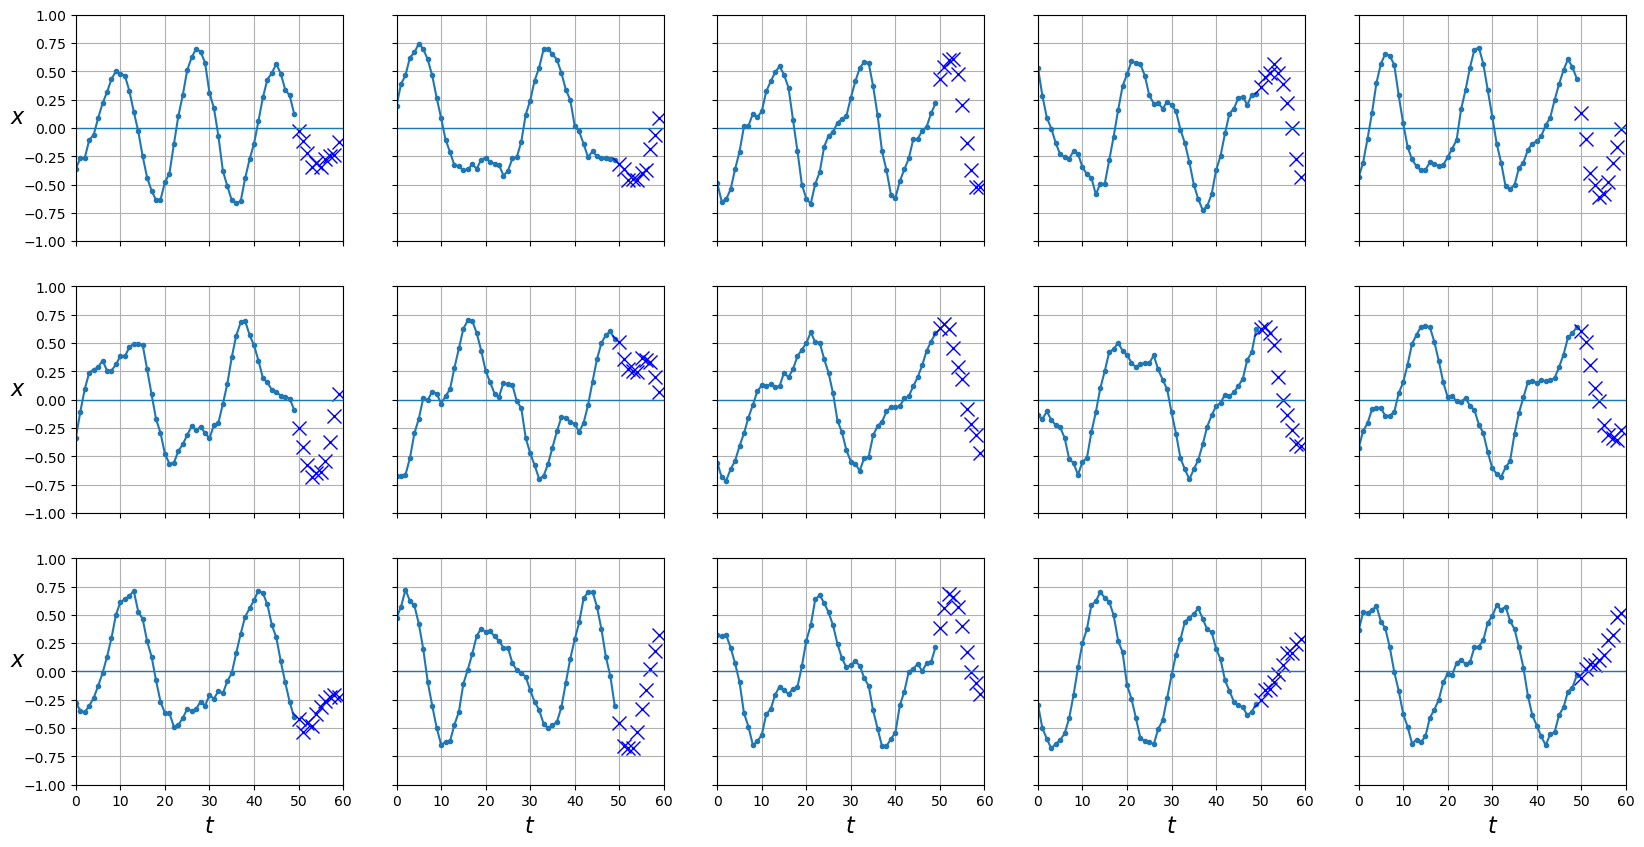

In [13]:
plot_series(X_test, Y_test)

可以尝试使用RNN模型来完成这项任务，既然它能够预测最后一个值。那么，每当我们预测出一个值时，将其添加为输入的一部分，并预测下一个值，这样直到我们想要停止为止。

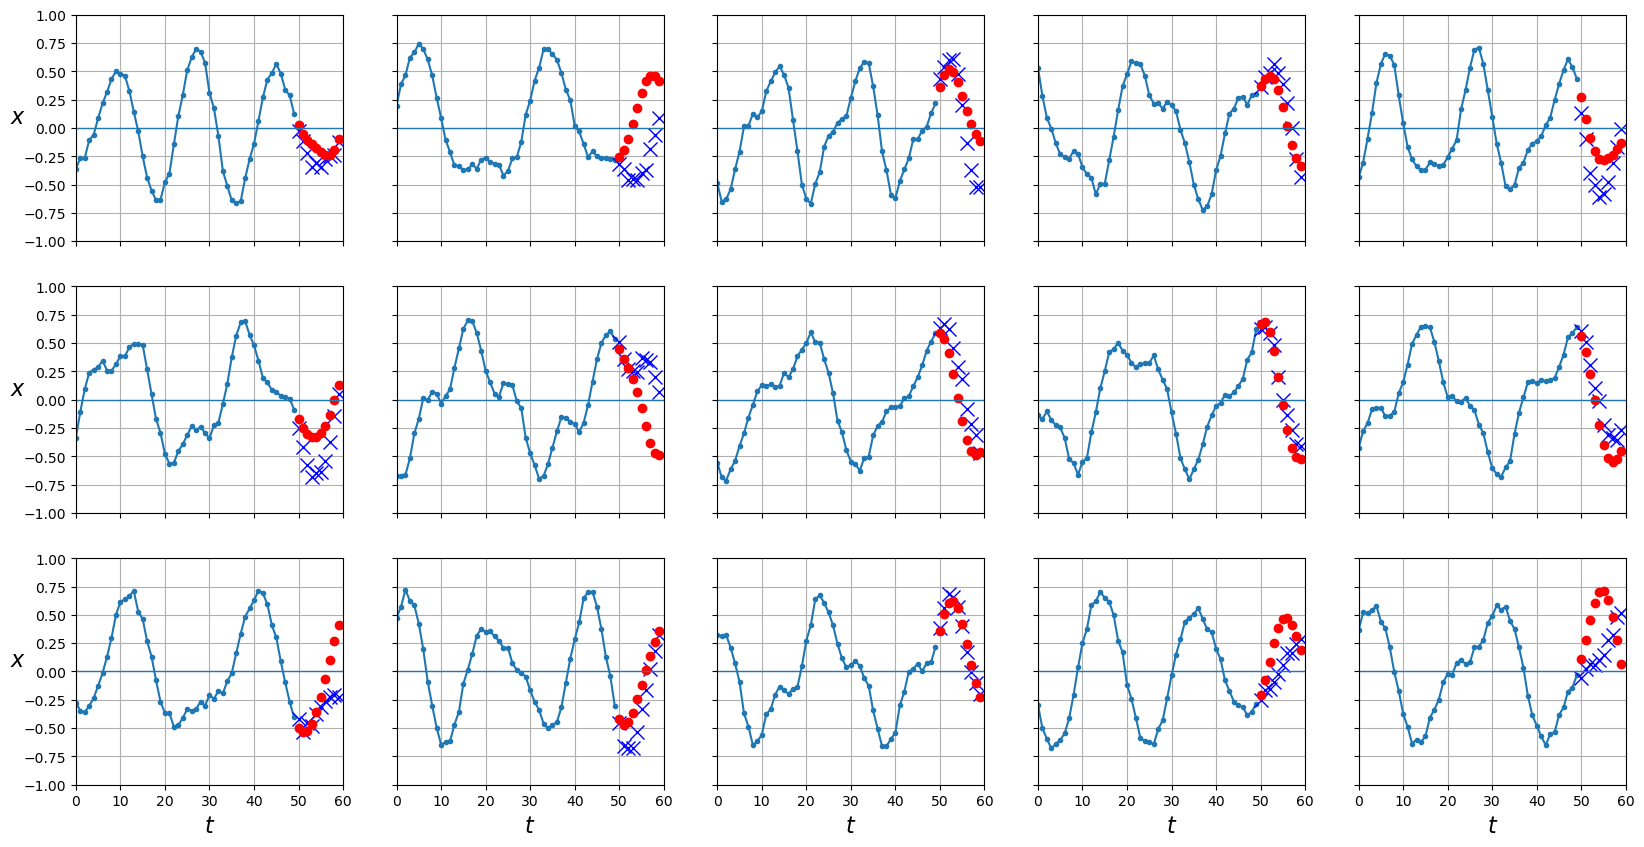

0.07910596579313278

In [14]:
X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, Y_test, y_pred)
mean_squared_error(Y_test, y_pred)

这种方法很有用，实际上也被用于很多应用中。

但是，模型中的任何错误也会在连续的预测中被传播。这可以发现，我们在预测的最初时间阶段非常准确，但随着我们对未来值更多的预测，预测结果会逐渐变差。

从事实中可以看出：我们可以通过让模型在每个时刻预测接下来的10个时间点而不是仅仅1个来改善我们的结果。

In [15]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [16]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.01555 val_loss 0.01460: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


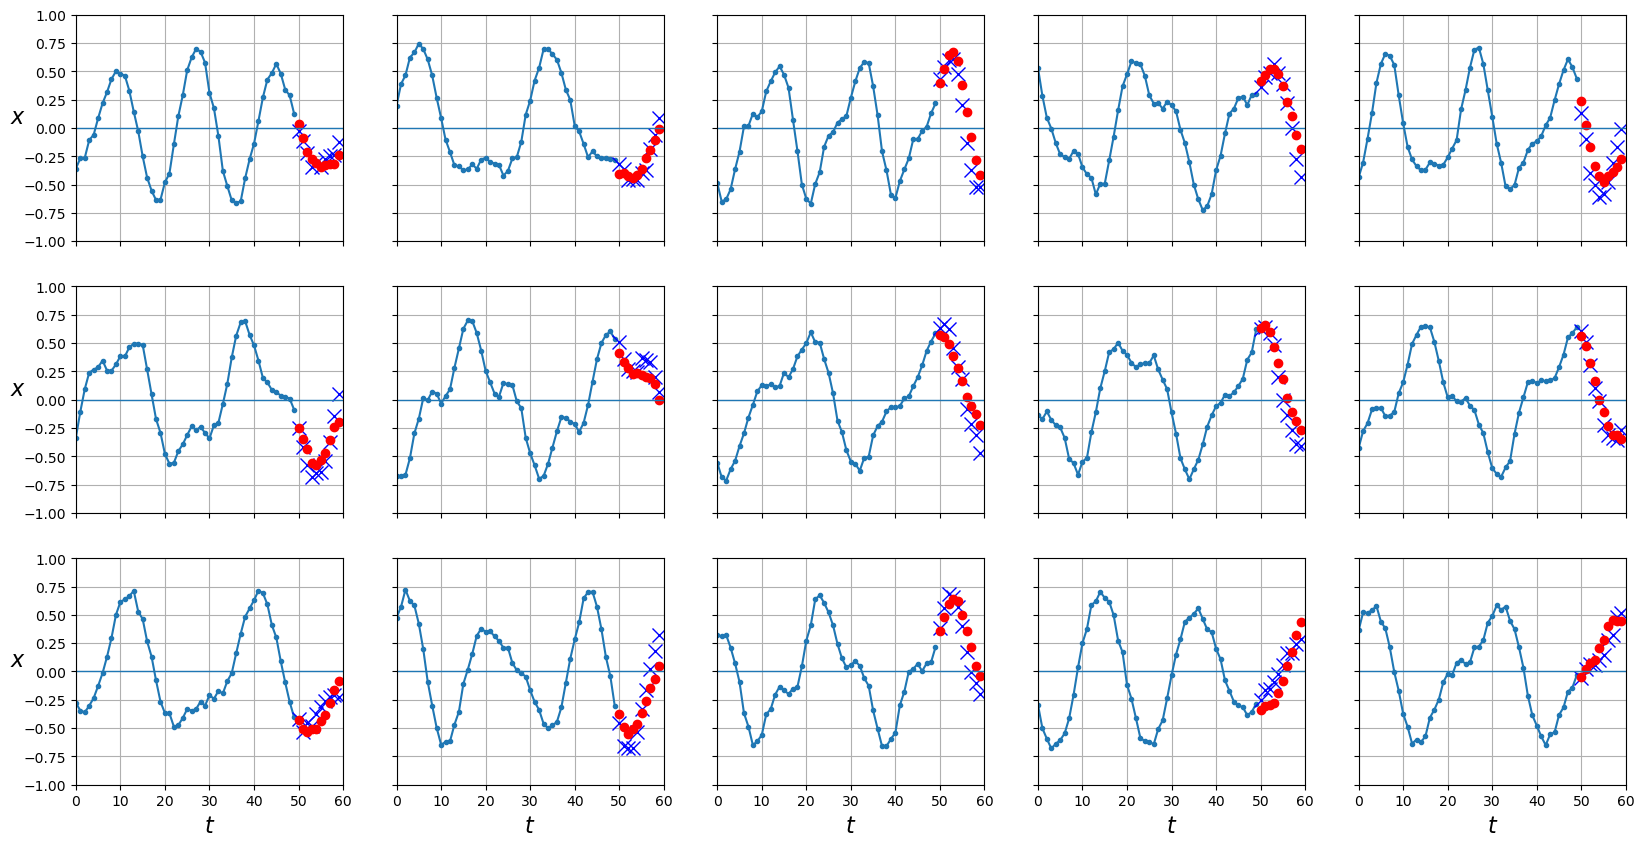

0.014764459803700447

In [17]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test, y_pred.cpu().numpy())
mean_squared_error(Y_test, y_pred.cpu())

如图所见，修正后模型预测的错误要小得多，因为我们已经训练了RNN在每个时间点预测10个值。

即便如此，如果仔细观察实现过程，我们会发现仅使用最后一个时间点的输出对网络模型进行了优化。

这意味着如果我们针对每个时间点进行优化，可以进一步改进我们的模型。

In [18]:
n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

从实现的角度来看，必须考虑到我们的FC层仅在最后一步将隐藏层的神经元与输出连接起来。为了能够针对所有时刻进行优化，我们必须以如下所示的方式压缩批次的维度和时间瞬间。

In [19]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

由于我们只对最后10个值感兴趣，因此我们仅针对这些值计算我们的指标。

In [20]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

In [21]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.03501 loss_last_step 0.02109 val_loss 0.03615 val_loss_last_step 0.02497: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


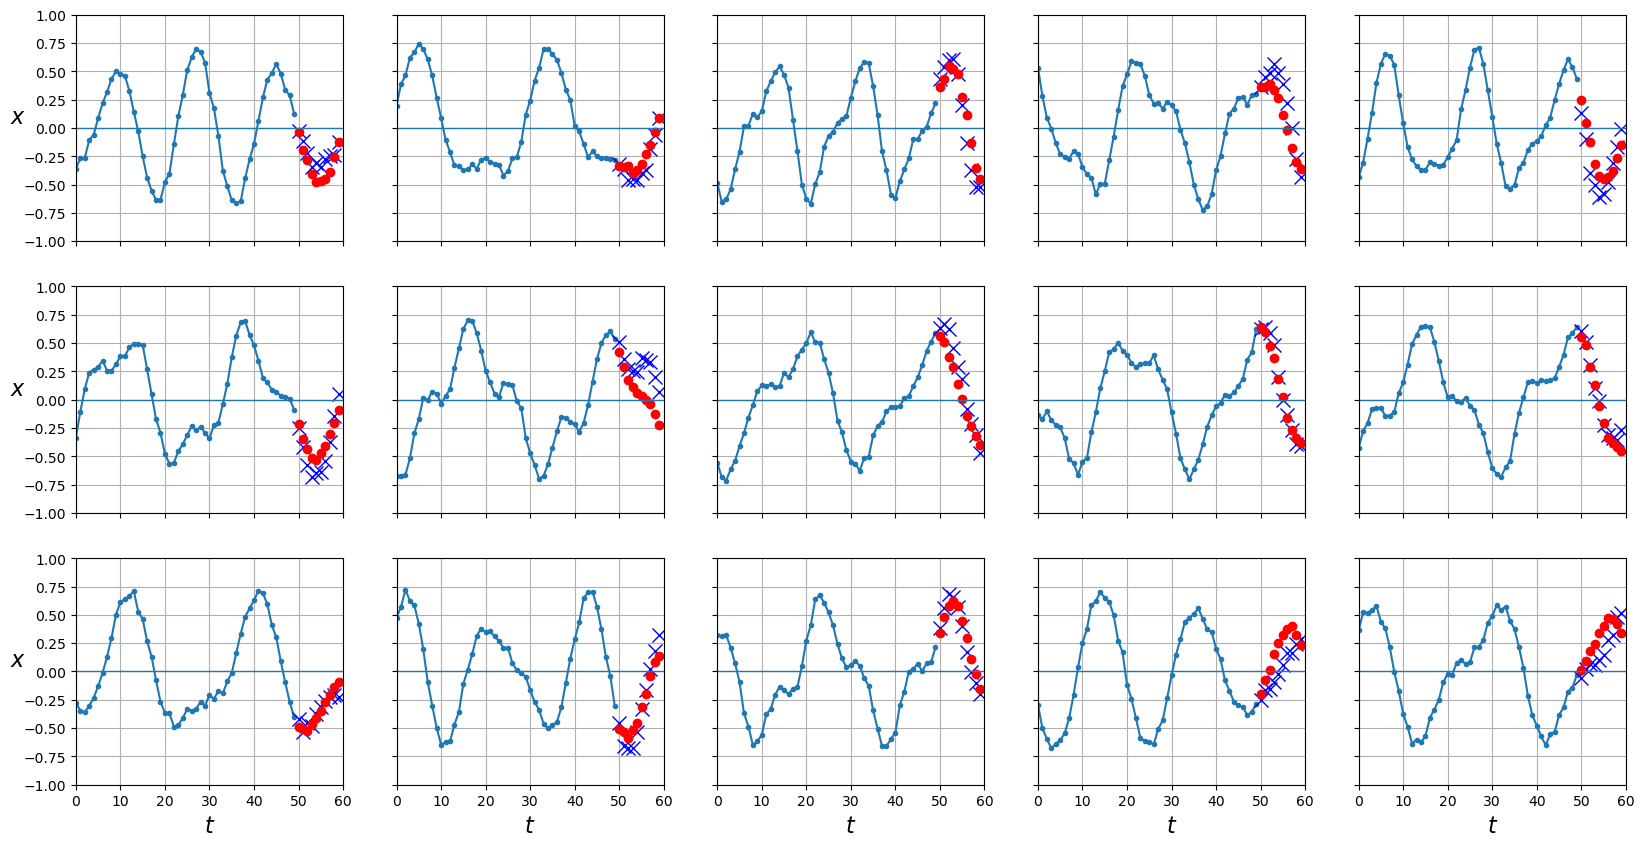

0.026000838726758957

In [22]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

在每个时间步进行优化时，反向传播阶段我们有更多的梯度在流动，并不仅从最后一个输出开始（这可能是有问题的，因为在最初的迭代中，到达的梯度可能已经消失了）。

## 置信区间

在时间序列预测中，通常会为我们的预测提供置信区间。有几种方法可以实现这一点，在这里我们将看到一种使用Dropout的简单技术。torch.nn.RNN类已经实现了Dropout层，所以我们只需要为它提供一个概率值。

In [23]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True, dropout=dropout)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [24]:
rnn = DeepRNN(dropout=0.3)
fit(rnn, dataloader)

loss 0.04148 loss_last_step 0.03120 val_loss 0.03974 val_loss_last_step 0.02932: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


dropout层在训练期间会随机关闭神经元，然而在进行预测时我们要使用所有的神经元。为了获得置信区间，我们以这种方式防止这种行为：即当我们要进行预测时，使网络应用不同的配置。最后，我们将计算所有预测的平均值以获得最终预测以及其标准偏差以计算置信区间。

In [25]:
def predict(model, dataloader):
    model.train()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [26]:
y_preds = np.stack([predict(rnn, dataloader['test']).cpu().numpy() for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred_std = y_preds.std(axis=0)

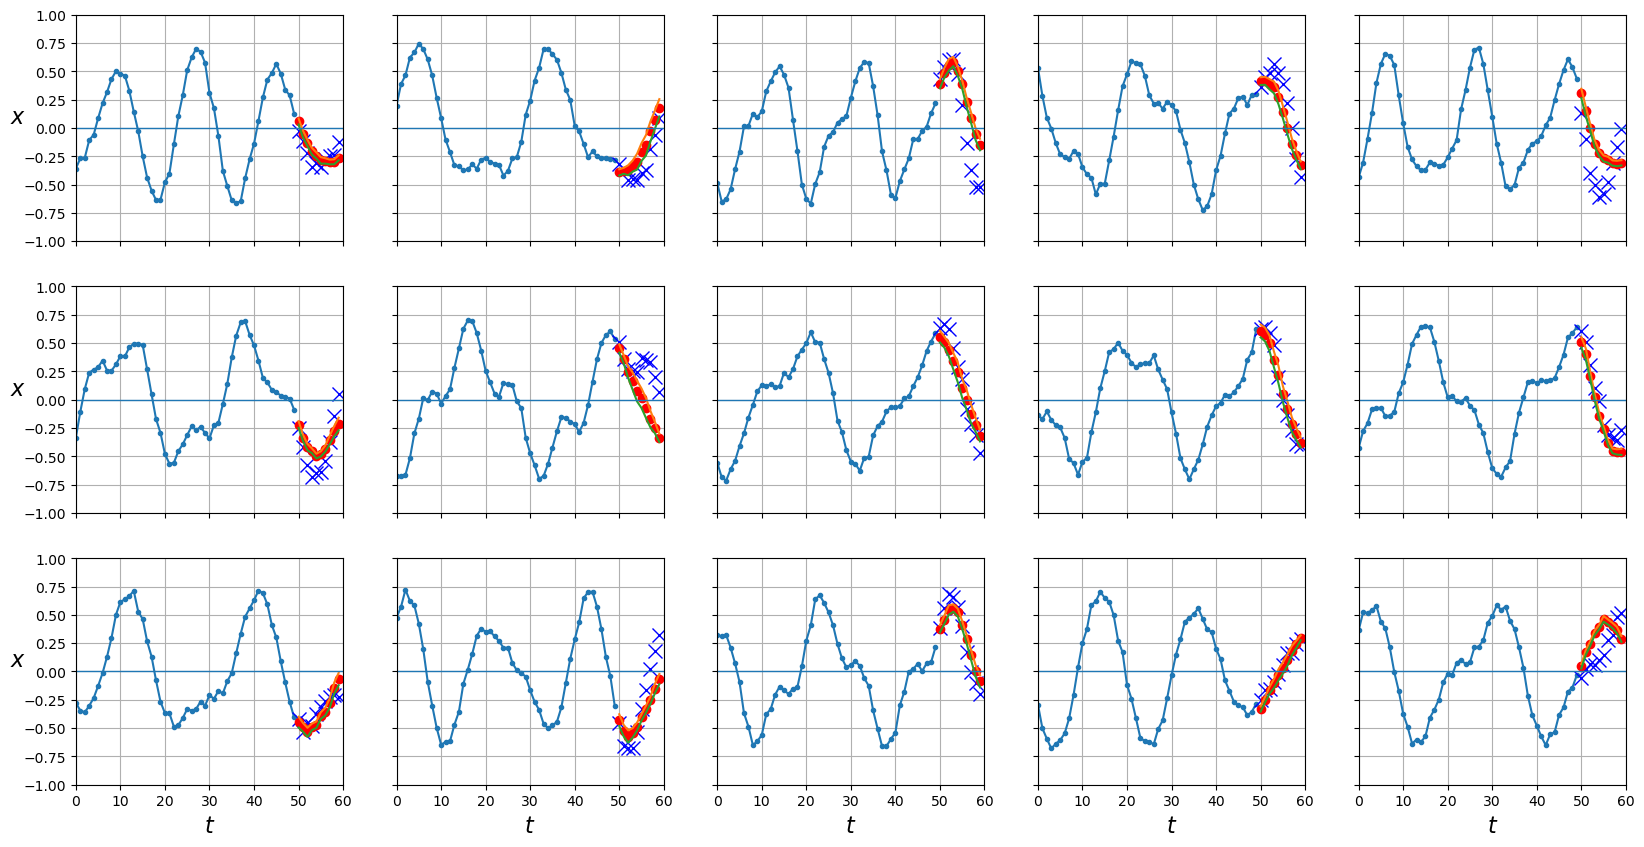

In [27]:
plot_series(X_test, Y_test[:,-1], y_pred[:,-1], y_pred_std[:, -1])

## 总结

时间序列预测在众多应用中非常有用，例如金融、医疗等领域。RNN 是处理此类数据（顺序数据）的理想架构，在上面的代码示例中，我们已经看到了如何应用它们来预测时间序列中的值。

预测最后一个值有助于我们更好地理解此类网络的运作方式，然而，我们的兴趣在于能够同时预测多个值（一整周、一个月、一年）。

我们已经看到了如何有效地训练此类网络以及给出我们预测的置信区间。虽然在我们的示例中已经获得了良好的结果，但我们当前的循环网络模型在处理更长的时间序列（数百个时间瞬间的量级）时还是会出现问题。